## Libraries and Dependencies

In [8]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.interpolate import griddata

!pip install pyDOE
from pyDOE import lhs

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

np.random.seed(1234)

In [9]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [10]:
# Multi-layer Perceptron (Deep Neural Network)
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [30]:
# Physics Informed Neural Network
class PINN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )

        self.iter = 0

    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        u = self.net_u(x, t)
        
        du_dt = torch.autograd.grad(inputs=t, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dx = torch.autograd.grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dxx = torch.autograd.grad(inputs=x, outputs=du_dx, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0]
        
        f = du_dt + u * du_dx - self.nu * du_dxx
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print('Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item()))
        return loss
    
    def train(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [31]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')
# print("Data shape: ",len(data))
# print("Data: ", data)

for key in data:
    print("key:", key)
    print("key shape:",type(data[key]))

print(data['x'].shape)
print(data['t'].shape)
print(data['usol'].shape)
    
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)
print("X:", X.shape)
print("T:", T.shape)

key: __header__
key shape: <class 'bytes'>
key: __version__
key shape: <class 'str'>
key: __globals__
key shape: <class 'list'>
key: x
key shape: <class 'numpy.ndarray'>
key: t
key shape: <class 'numpy.ndarray'>
key: usol
key shape: <class 'numpy.ndarray'>
(256, 1)
(100, 1)
(256, 100)
X: (100, 256)
T: (100, 256)


In [13]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

print("xx1:", xx1.shape)
print("uu1:", uu1.shape)
print("xx2:", xx2.shape)
print("uu2:", uu2.shape)
print("xx3:", xx3.shape)
print("uu3:", uu3.shape)

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

print("X_u_train:", X_u_train.shape)
print("u_train:", u_train.shape)

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# print("idx:",idx)
# print("idx size:",len(idx))
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

print("X_u_train:", X_u_train.shape)
print("X_f_train:", X_f_train.shape)
print("u_train:", u_train.shape)

xx1: (256, 2)
uu1: (256, 1)
xx2: (100, 2)
uu2: (100, 1)
xx3: (100, 2)
uu3: (100, 1)
X_u_train: (456, 2)
u_train: (456, 1)
X_u_train: (100, 2)
X_f_train: (10456, 2)
u_train: (100, 1)


## Training

In [32]:
model = PINN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)
model.train()

Iter 100, Loss: 8.34867e-02, Loss_u: 5.63073e-02, Loss_f: 2.71794e-02
Iter 200, Loss: 4.40323e-02, Loss_u: 2.78140e-02, Loss_f: 1.62183e-02
Iter 300, Loss: 2.42649e-02, Loss_u: 1.29679e-02, Loss_f: 1.12970e-02
Iter 400, Loss: 1.21009e-02, Loss_u: 5.70433e-03, Loss_f: 6.39655e-03
Iter 500, Loss: 7.26242e-03, Loss_u: 2.97360e-03, Loss_f: 4.28882e-03
Iter 600, Loss: 5.31388e-03, Loss_u: 2.04845e-03, Loss_f: 3.26543e-03
Iter 700, Loss: 3.80894e-03, Loss_u: 1.10383e-03, Loss_f: 2.70511e-03
Iter 800, Loss: 2.91774e-03, Loss_u: 7.99850e-04, Loss_f: 2.11789e-03
Iter 900, Loss: 2.37761e-03, Loss_u: 6.87013e-04, Loss_f: 1.69059e-03
Iter 1000, Loss: 1.85984e-03, Loss_u: 5.60336e-04, Loss_f: 1.29950e-03
Iter 1100, Loss: 1.55403e-03, Loss_u: 4.26728e-04, Loss_f: 1.12730e-03
Iter 1200, Loss: 1.18083e-03, Loss_u: 3.83768e-04, Loss_f: 7.97061e-04
Iter 1300, Loss: 9.96539e-04, Loss_u: 3.42852e-04, Loss_f: 6.53686e-04
Iter 1400, Loss: 8.14530e-04, Loss_u: 2.75719e-04, Loss_f: 5.38811e-04
Iter 1500, Loss

In [33]:
u_pred, f_pred = model.predict(X_star)

# Relative L2 Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

# Absolute error
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 2.136844e-02


## Visualizations

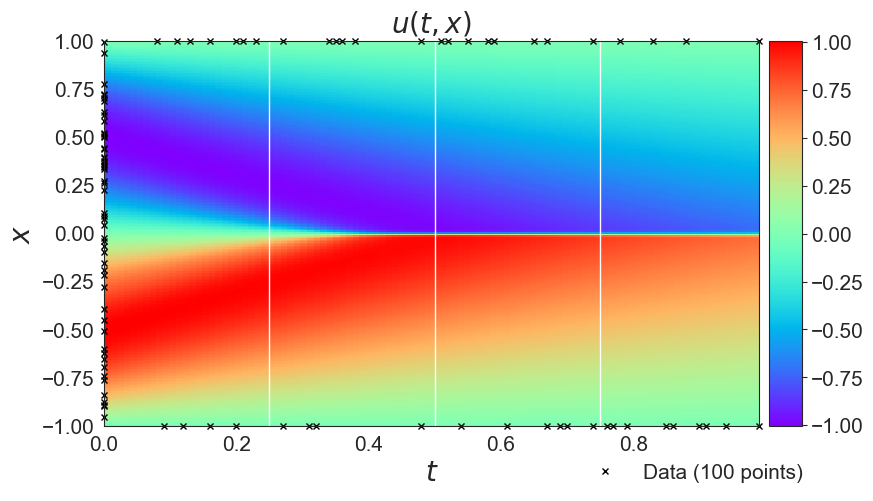

In [34]:
####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

C:\Users\ameyv\AppData\Local\Temp\ipykernel_30216\1452404817.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


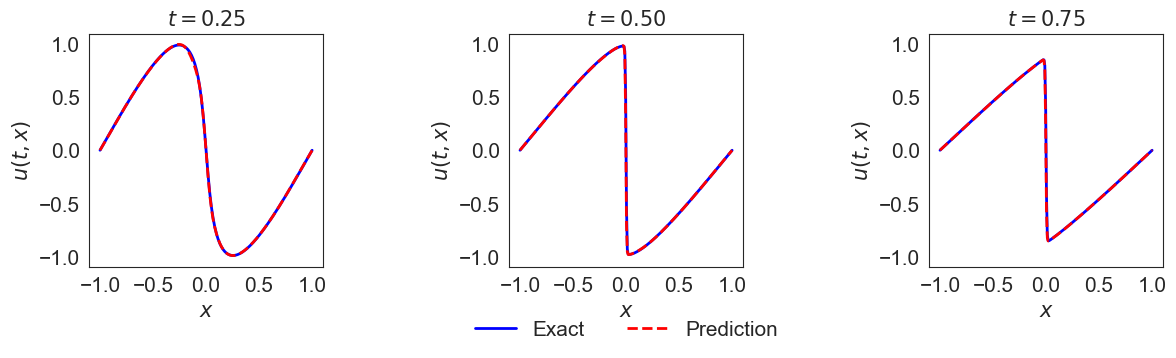

In [35]:
####### Row 1: u(t,x) slices ################## 

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()